In [1]:
import torch
import importlib

In [2]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [3]:
import torch
import matplotlib.pyplot as plt

BATCH_SIZE = 4 # increase / decrease according to GPU memeory
RESIZE_TO = 512 # resize the image for training and transforms
NUM_EPOCHS = 1 # number of epochs to train for

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = 'data/out_rgb'
# validation images and XML files directory
VALID_DIR = 'data/out_rgb'

# classes: 0 index is reserved for background
CLASSES = [
    '0', '1', '2', '3', '4'
]
NUM_CLASSES = 5

# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = False

# location to save model and plots
# OUT_DIR = '../outputs'
OUT_DIR = 'outputs'
SAVE_PLOTS_EPOCH = 2 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 2 # save model after these many epochs

In [4]:
import albumentations as A
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2
from config import DEVICE, CLASSES as classes
# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [5]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [6]:
# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

def get_train_transform_without_boxes():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0)
    ])

# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [7]:
def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box in boxes:
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
            cv2.imshow('Transformed image', sample)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

In [8]:
import torch
import cv2
import numpy as np
import os
import glob as glob
from xml.etree import ElementTree as et
import json
# from config import CLASSES, RESIZE_TO, TRAIN_DIR, VALID_DIR, BATCH_SIZE

# from config import CLASSES, RESIZE_TO, BATCH_SIZE
from torch.utils.data import Dataset, DataLoader
# from utils import collate_fn, get_train_transform, get_valid_transform

In [9]:
# the dataset class
class MicrocontrollerDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None, transforms_without_boxes=None):
        self.transforms_without_boxes = transforms_without_boxes
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order    
        self.image_paths = glob.glob(f"{self.dir_path}/*.png")
        self.all_images = [image_path.split('/')[-1].split('.')[0] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)
        self.all_classes = set()

        # FileNames Dictionary
        self.filenames = dict()
        for sub_dir, dir_name, files in os.walk("data/out_bbox/"):
            for file in files:
                try:
                    with open("data/out_bbox/" + file, 'r') as fp:
                        file = file.split('.')[0]
                        self.filenames[file] = json.load(fp)
                        self.all_classes.update(self.filenames[file]["vehicle_class"])
                except Exception as e:
                    pass
                
    def check_bounding_boxes(self, box_coordinates):
        box_coords = []
        for coordinate in box_coordinates:
            if coordinate < 1:
                box_coords.append(1)
            elif coordinate > self.width:
                box_coords.append(self.width)
            else:
                box_coords.append(coordinate)
        if box_coords[0] == box_coords[2]:
            if box_coords[2] != self.width:
                box_coords[2] += 5
            else:
                box_coords[0] -= 5
        if box_coords[1] == box_coords[3]:
            if box_coords[3] != self.width:
                box_coords[3] += 5
            else:
                box_coords[1] -= 5
        return box_coords
                    
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name + '.png')
        # read the image
        # print(image_path)
        # image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image = cv2.imread(image_path)
        # plt.imshow(image)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        # plt.imshow(image_resized)
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        image_annotation_dict = self.filenames[image_name]
        
        boxes = []
        if image_annotation_dict["bboxes"]:
            for box_coordinates in self.filenames[image_name]["bboxes"]:
                if box_coordinates:
                    xmin = box_coordinates[0][0]
                    ymin = box_coordinates[0][1]
                    xmax = box_coordinates[1][0]
                    ymax = box_coordinates[1][1]
                    
                    xmin_final = (xmin/image_width)*self.width
                    xmax_final = (xmax/image_width)*self.width
                    ymin_final = (ymin/image_height)*self.height
                    ymax_final = (ymax/image_height)*self.height
                    box_coordinates_loc = [xmin_final, ymin_final, xmax_final, ymax_final]
                    boxes.append(self.check_bounding_boxes(box_coordinates_loc))
                    # boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
        labels_orig = image_annotation_dict["vehicle_class"]
        labels = []
        for label in labels_orig:
            labels.append(label + 1)

        num_objs = len(boxes)
        
        if not boxes:
            # print("Came Inside")
            boxes = torch.zeros((0,4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
            area = torch.zeros(0, dtype=torch.float32)
        else:
            # bounding box to tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # print(boxes)
            # labels to tensor
            labels = torch.as_tensor(labels, dtype=torch.int64)
            # area of the bounding boxes
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # no crowd instances
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        # apply the image transforms
        # print(labels)
        # print(boxes)
        if self.transforms:
            # if num_objs == 0:
            #     print("Before Transformation:", target['boxes'])
            if num_objs != 0:
                try:
                    sample = self.transforms(image = image_resized,
                                             bboxes = boxes,
                                             labels = labels)
                    target_boxes = []
                    for box in sample['bboxes']:
                        target_box = []
                        for box_coordinate in box:
                            if box_coordinate < 1:
                                target_box.append(0)
                            elif box_coordinate > self.width:
                                target_box.append(self.width)
                            else:
                                target_box.append(box_coordinate)
                        if target_box[0] == target_box[2]:
                            if target_box[2] != self.width:
                                target_box[2] += 5
                            else:
                                target_box[0] -= 5
                        if target_box[3] == target_box[1]:
                            if target_box[3] != self.height:
                                target_box[3] += 5
                            else:
                                target_box[1] -= 5
                        target_boxes.append(target_box)
                    # target['boxes'] = torch.Tensor(sample['bboxes'])
                    target['boxes'] = torch.Tensor(target_boxes)
                except:
                    sample = dict()
                    sample['image'] = torch.tensor(image_resized).permute(2,0,1)
                    print("Boxes Exception:", boxes)
            else:
                sample = self.transforms_without_boxes(image = image_resized)
                target['boxes'] = torch.zeros((0,4), dtype=torch.float32)
                target['labels'] = torch.zeros(0, dtype=torch.int64)
                target['area'] = torch.zeros(0, dtype=torch.float32)
            image_resized = sample['image']
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

In [10]:
# prepare the final datasets and data loaders
train_dataset = MicrocontrollerDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform(), get_train_transform_without_boxes())
valid_dataset = MicrocontrollerDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform(), get_train_transform_without_boxes())
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 2779
Number of validation samples: 2779



In [11]:
train_dataset.all_classes

{0, 1, 2, 3}

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, rpn_nms_thresh=0.0, box_score_thresh=0.0, box_detections_per_img=100)
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [13]:
# image_tensor_list = list(train_dataset[0][0].unsqueeze(dim=0).float()) + list(train_dataset[1][0].unsqueeze(dim=0).float())
image_tensor_list = list(train_dataset[0][0].unsqueeze(dim=0).float())

In [14]:
len(image_tensor_list)

1

In [15]:
NUM_CLASSES

5

In [16]:
model = create_model(num_classes=NUM_CLASSES)

In [17]:
# model

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load(
    'outputs/model10.pth', map_location=device
))

<All keys matched successfully>

In [19]:
model.eval()
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# model.fc0.conv2.register_forward_hook(get_activation('fc0.conv2'))
# model.fc1.conv2.register_forward_hook(get_activation('fc1.conv2'))

model.rpn.head.cls_logits.register_forward_hook(get_activation('rpn.head.cls_logits'))
model.rpn.head.bbox_pred.register_forward_hook(get_activation('rpn.head.bbox_pred'))
model.roi_heads.box_roi_pool.register_forward_hook(get_activation('roi_heads.box_roi_pool'))
model.rpn.head.conv.register_forward_hook(get_activation('rpn.head.conv'))
model.backbone.body.conv1.register_forward_hook(get_activation('backbone.body.conv1'))
# model.transform.register_forward_hook(get_activation('transform'))

output = model(image_tensor_list)
print(activation['rpn.head.cls_logits'].shape)
print(activation['rpn.head.bbox_pred'].shape)
print(activation['roi_heads.box_roi_pool'].shape)
print(activation['rpn.head.conv'].shape)
print(activation['backbone.body.conv1'].shape)
# print(activation['transform'])

X Type: <class 'torch.Tensor'> X Shape: torch.Size([1, 3, 800, 800])


/home/karthikragunath/anaconda3/envs/semantic_scene_understanding/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/karthikragunath/anaconda3/envs/semantic_scene_understanding/lib/python3.8/site-packages/torchvision/models/detection/roi_heads.py:860: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature_vectors = torch.tensor(feature_vectors)


************************************************** Proposals: tensor([[[ -22.6435,   -6.2656,    7.6224,    6.3383],
         [ -17.2229,  -13.8710,    5.8248,    7.1291],
         [  -7.3725,  -23.7137,    5.1513,    4.4546],
         ...,
         [ 425.2282,  598.1815, 1268.2894,  853.9525],
         [ 536.8384,  480.4920, 1003.0582,  978.3440],
         [ 636.8804,  408.4968,  874.7362, 1162.1571]]]) **************************************************
X Shape: torch.Size([65, 1024])
Score Values: tensor([[-8.6137e-01,  5.6200e+00,  5.4805e-01, -2.2146e+00, -4.0371e+00],
        [ 3.0501e+00,  4.2411e+00,  4.6249e+00,  1.0283e+00,  1.0039e+00],
        [ 4.5461e+00,  2.7855e+00,  1.9343e+00,  3.2000e+00,  3.6995e+00],
        [ 6.0241e+00,  1.9642e+00,  6.2587e-02,  3.4596e-01,  7.2094e-01],
        [ 3.2235e+00, -9.1032e-02, -1.1588e+00, -1.4890e+00, -1.1090e+00],
        [ 4.7358e+00, -1.6293e-01, -2.2943e+00, -2.2839e+00, -2.0300e+00],
        [ 2.9937e+00, -5.9119e-02, -2.5748e+0

UnboundLocalError: local variable 'gmm' referenced before assignment

In [ ]:
output

In [ ]:
print(output[0]['boxes'].shape, output[0]['labels'].shape, output[0]['scores'].shape, output[0]['feature_vector'].shape, output[0]['proposals'].shape)

In [ ]:
train_dataset[0][0].shape

In [ ]:
# numpy_image = train_dataset[0][0].numpy()

In [ ]:
# numpy_image.shape

In [ ]:
# numpy_image = np.transpose(numpy_image, (1, 2, 0)).astype(np.float)

In [ ]:
# numpy_image.shape

In [ ]:
original_image_tensor = train_dataset[0][0]

In [ ]:
original_image_tensor.shape

In [ ]:
# original_image_tensor = original_image_tensor.permute(1,2,0)

In [ ]:
# original_image_tensor.shape

In [ ]:
import torchvision.transforms as T
input_transform = T.Compose([
                          # T.ToTensor(),
                          # T.Resize(size=(width, height)),
                          # T.Grayscale(),
                          # T.Normalize((0.5), (0.5)),
                          # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                          T.Resize(size=(800,800))
                          ])

In [ ]:
# transformed_image = input_transform(numpy_image)
transformed_image = input_transform(original_image_tensor)

In [53]:
transformed_image.shape

torch.Size([3, 800, 800])

In [54]:
proposals = output[0]['proposals']

In [55]:
proposals[0:3].shape

torch.Size([3, 4])

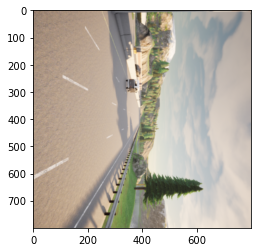

In [56]:
plt.imshow(transformed_image.permute(1, 2, 0))

In [57]:
transformed_image.shape

torch.Size([3, 800, 800])

In [58]:
from torchvision.utils import save_image
save_image(transformed_image, 'saved_image.png')

In [59]:
# transformed_image_cv = cv2.cvtColor(transformed_image, cv2.COLOR_GRAY2BGR)

In [60]:
transformed_cv_image = cv2.imread('saved_image.png')

In [61]:
draw_boxes = proposals

In [62]:
draw_boxes

tensor([[ -17.2264,   -4.1699,    8.5420,    7.4497],
        [ -14.6156,  -13.4699,    8.2655,    8.1479],
        [  -4.2125,  -19.6805,    7.2903,    4.6485],
        ...,
        [ 407.2225,  597.3430, 1244.1104,  857.4995],
        [ 518.3290,  473.9682,  985.9883,  976.4352],
        [ 634.2145,  401.5269,  874.4710, 1145.8643]])

In [63]:
draw_boxes.shape

torch.Size([159882, 4])

In [64]:
draw_boxes = proposals[-100:]
test_image = transformed_cv_image.copy()
for j, box in enumerate(draw_boxes):
    for i in range(4):
        if int(box[i]) <= 0:
            box[i] = 0
        if int(box[i]) >= 800:
            box[i] = 800
    cv2.rectangle(test_image,
                (int(box[0]), int(box[1])),
                (int(box[2]), int(box[3])),
                (0, 0, 255), 2)

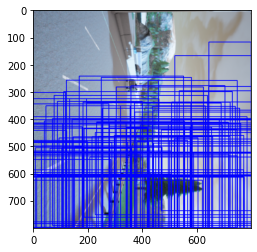

In [65]:
plt.imshow(test_image)

In [66]:
draw_boxes

tensor([[122.1771, 257.3495, 460.2938, 800.0000],
        [  0.0000, 391.2294, 785.5726, 800.0000],
        [ 77.7594, 313.8209, 640.4544, 800.0000],
        [169.1915, 242.5943, 552.0565, 800.0000],
        [  0.0000, 421.1916, 800.0000, 783.2533],
        [112.2771, 299.6787, 731.5365, 800.0000],
        [250.0616, 247.3238, 581.9246, 800.0000],
        [  0.0000, 414.3203, 800.0000, 777.9077],
        [183.7919, 338.5411, 723.3765, 800.0000],
        [305.6467, 282.5980, 625.4016, 800.0000],
        [ 71.1411, 398.1123, 800.0000, 790.6497],
        [254.6075, 360.4453, 758.6652, 800.0000],
        [359.1776, 277.4514, 704.6506, 800.0000],
        [187.0633, 435.7653, 800.0000, 760.5328],
        [373.6638, 374.4069, 800.0000, 800.0000],
        [422.7136, 258.8792, 749.1821, 800.0000],
        [228.2351, 449.9551, 800.0000, 751.7693],
        [439.0704, 367.2556, 800.0000, 800.0000],
        [520.0734, 167.9792, 800.0000, 800.0000],
        [470.8373, 440.4730, 800.0000, 736.9163],


/tmp/ipykernel_1126330/3526060162.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = np.transpose(image, (2, 0, 1)).astype(np.float)


Image: tensor([[[[0.5608, 0.5765, 0.5922,  ..., 0.4941, 0.4902, 0.4902],
          [0.5725, 0.5882, 0.6000,  ..., 0.7176, 0.7137, 0.7137],
          [0.5843, 0.5922, 0.6039,  ..., 0.9608, 0.9608, 0.9608],
          ...,
          [0.6157, 0.6314, 0.6510,  ..., 0.8667, 0.8706, 0.8706],
          [0.6235, 0.6314, 0.6431,  ..., 0.8667, 0.8667, 0.8706],
          [0.6353, 0.6353, 0.6353,  ..., 0.8667, 0.8667, 0.8706]],

         [[0.4941, 0.5059, 0.5137,  ..., 0.3020, 0.3020, 0.3020],
          [0.4980, 0.5098, 0.5216,  ..., 0.5294, 0.5294, 0.5294],
          [0.4980, 0.5098, 0.5216,  ..., 0.7843, 0.7843, 0.7843],
          ...,
          [0.5137, 0.5333, 0.5529,  ..., 0.8157, 0.8157, 0.8196],
          [0.5294, 0.5373, 0.5451,  ..., 0.8157, 0.8157, 0.8157],
          [0.5412, 0.5412, 0.5373,  ..., 0.8157, 0.8157, 0.8157]],

         [[0.4196, 0.4392, 0.4588,  ..., 0.2314, 0.2275, 0.2275],
          [0.4353, 0.4549, 0.4745,  ..., 0.4078, 0.4039, 0.4039],
          [0.4431, 0.4667, 0.4863, 

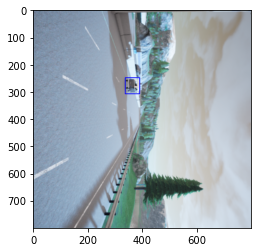

In [67]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = create_model(num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(
    'outputs/model10.pth', map_location=device
))
# model.eval()
model.eval()
test_images = ['saved_image.png']
image = cv2.imread(test_images[0])
orig_image = image.copy()
# BGR to RGB
image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
# make the pixel range between 0 and 1
image /= 255.0
# bring color channels to front
image = np.transpose(image, (2, 0, 1)).astype(np.float)
# convert to tensor
image = torch.tensor(image, dtype=torch.float).cuda()
# add batch dimension
image = torch.unsqueeze(image, 0)
print("Image:", image)
with torch.no_grad():
    outputs = model(image)
detection_threshold = 0.8

# load all detection to CPU for further operations
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
# carry further only if there are detected boxes
if len(outputs[0]['boxes']) != 0:
    boxes = outputs[0]['boxes'].data.numpy()
    scores = outputs[0]['scores'].data.numpy()
    # filter out boxes according to `detection_threshold`
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    draw_boxes = boxes.copy()
    # get all the predicited class names
    pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

    # draw the bounding boxes and write the class name on top of it
    for j, box in enumerate(draw_boxes):
        cv2.rectangle(orig_image,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    (0, 0, 255), 2)
        # cv2.putText(orig_image, pred_classes[j], 
        #             (int(box[0]), int(box[1]-5)),
        #             cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
        #             2, lineType=cv2.LINE_AA)
    # cv2.imshow('Prediction', orig_image)
    # cv2.waitKey(1)
    # cv2.imwrite(f"../test_predictions/{image_name}.jpg", orig_image,)
    plt.imshow(orig_image)
    plt.savefig("test_prediction.png")
print(f"Image {i+1} done...")
print('-'*50)
print('TEST PREDICTIONS COMPLETE')
# cv2.destroyAllWindows()

In [68]:
outputs

[{'boxes': tensor([[338.6972, 248.8891, 391.5556, 307.2157],
          [373.8413, 197.1898, 397.0529, 250.0652],
          [374.5118, 195.3031, 397.4099, 247.4791],
          [371.4417, 282.1608, 388.3365, 304.3106],
          [382.8373, 324.9407, 394.7439, 333.3106],
          [373.9644, 247.4138, 389.6244, 277.4617],
          [366.2473, 130.0312, 381.1411, 151.7648],
          [365.8042, 131.2967, 381.1264, 152.1911],
          [382.0020, 324.5118, 394.3811, 334.1112],
          [382.9269, 325.2172, 394.0112, 333.2086],
          [337.6909, 252.0516, 390.5266, 309.6690],
          [371.2044, 323.5140, 383.0859, 330.6215],
          [338.3750, 250.7954, 353.0054, 266.5569],
          [367.8692, 146.9170, 381.9577, 163.2228],
          [367.2990, 195.7452, 401.5148, 243.2594],
          [368.2804, 146.3115, 382.2216, 163.4565],
          [365.6562, 131.0747, 380.3655, 149.5885],
          [371.0208, 282.1977, 387.7740, 301.9006],
          [337.0826, 229.7821, 396.0531, 337.7098],
   

In [69]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(